In [1]:
# cfg_flow_celltype.py
# Full script: classifier-free guidance trained on cell type
import os
from typing import Optional
import math
import anndata as ad
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from tqdm import tqdm

In [2]:
# ---- device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- paths (edit if needed)
input_file_path = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train_with_latent.h5ad"
flow_model_save_path = "/dtu/blackhole/1e/213566/models/simple_flow_model_state.pth"
generated_save_path = "/dtu/blackhole/1e/213566/gen_data/pbmc3k/simple_generated_latent.pt"
os.makedirs(os.path.dirname(flow_model_save_path), exist_ok=True)
os.makedirs(os.path.dirname(generated_save_path), exist_ok=True)

In [3]:


# ---- load data
adata = ad.read_h5ad(input_file_path)
latent = adata.obsm["X_latent"]
latent_tensor = torch.tensor(latent, dtype=torch.float32, device=device)
print("Shape of latent space:", latent.shape)

# ---- cell type labels
cell_types = adata.obs["cell_type"].astype(str).values
# map to indices
unique_types, inverse_idx = np.unique(cell_types, return_inverse=True)
num_cell_types = len(unique_types)
cell_type_idx = torch.tensor(inverse_idx, dtype=torch.long, device=device)  # length N

print(f"Found {num_cell_types} cell types: {unique_types}")

Shape of latent space: (2110, 50)
Found 8 cell types: ['B cells' 'CD14+ Monocytes' 'CD4 T cells' 'CD8 T cells' 'Dendritic cells'
 'FCGR3A+ Monocytes' 'Megakaryocytes' 'NK cells']


In [4]:
# ---- Empirical distribution (KDE-like sampler/log density)
class EmpiricalDistribution(torch.nn.Module):
    def __init__(self, data: torch.Tensor, bandwidth: Optional[float] = None, compute_log_density: bool = True):
        super().__init__()
        assert data.dim() == 2, "data must be shape (N, D)"
        data = data.contiguous()
        self.register_buffer("data", data)   # (N, D)
        self.n = data.shape[0]
        self.data_dim = data.shape[1]
        self.compute_log_density_flag = compute_log_density

        # bandwidth scalar
        if bandwidth is None:
            std = torch.std(data, dim=0).mean().item()
            factor = (4.0 / (self.data_dim + 2.0)) ** (1.0 / (self.data_dim + 4.0))
            bw = factor * (self.n ** (-1.0 / (self.data_dim + 4.0))) * (std + 1e-6)
            bw = float(bw)
        else:
            bw = float(bandwidth)
        self.register_buffer("bandwidth", torch.tensor(bw, device=self.data.device))
        # log constant as tensor
        self._log_const = -0.5 * self.data_dim * math.log(2.0 * math.pi) - self.data_dim * torch.log(self.bandwidth)

    @property
    def dim(self):
        return self.data_dim

    def sample(self, num_samples: int) -> torch.Tensor:
        idx = torch.randint(0, self.n, (num_samples,), device=self.data.device)
        return self.data[idx]

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        if not self.compute_log_density_flag:
            raise RuntimeError("log_density disabled (compute_log_density=False).")
        assert x.dim() == 2 and x.shape[1] == self.data_dim
        x = x.to(self.data.device)
        x_norm2 = (x ** 2).sum(dim=1, keepdim=True)             # (bs,1)
        data_norm2 = (self.data ** 2).sum(dim=1).unsqueeze(0)    # (1, N)
        cross = x @ self.data.t()                               # (bs, N)
        d2 = x_norm2 + data_norm2 - 2.0 * cross
        sigma2 = (self.bandwidth ** 2)
        exponents = -0.5 * d2 / (sigma2 + 1e-12)
        lse = torch.logsumexp(exponents, dim=1, keepdim=True)
        log_prob = math.log(1.0 / self.n) + lse + self._log_const
        return log_prob

In [5]:
emp_dist = EmpiricalDistribution(latent_tensor)


In [6]:
# ---- Gaussian conditional path / analytic vector field
class LinearAlpha():
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return t
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return torch.ones_like(t)

class LinearBeta():
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return 1 - t
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return -torch.ones_like(t)

class GaussianConditionalProbabilityPath():
    def __init__(self, p_data, alpha, beta):
        self.p_data = p_data
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        return self.p_data.sample(num_samples)

    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # p_t(x|z) = N(alpha_t * z, beta_t^2 I)
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # u_t(x|z) as in your formula
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        dt_alpha_t = self.alpha.dt(t)
        dt_beta_t = self.beta.dt(t)
        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + (dt_beta_t / beta_t) * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

In [8]:

alpha = LinearAlpha()
beta = LinearBeta()
path = GaussianConditionalProbabilityPath(emp_dist, alpha, beta)

In [9]:

# ---- Neural vector field
class TimeEmbedder(nn.Module):
    def __init__(self, embed_dim=32, max_freq=1e4):
        super().__init__()
        assert embed_dim % 2 == 0
        self.embed_dim = embed_dim
        self.max_freq = max_freq
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU()
        )
    def forward(self, t):
        freqs = torch.exp(torch.linspace(0, math.log(self.max_freq), self.embed_dim // 2, device=t.device))
        args = t * freqs
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.mlp(emb)

class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )
    def forward(self, x):
        return x + self.block(x)

class NeuralVectorField(nn.Module):
    def __init__(self, latent_dim, hidden_dim=256, n_resblocks=3, time_embed_dim=64):
        super().__init__()
        self.x_proj = nn.Linear(latent_dim, hidden_dim)
        # z is cell-type conditioning vector projected into hidden_dim
        self.z_proj = nn.Linear(latent_dim, hidden_dim)
        self.time_embedder = TimeEmbedder(time_embed_dim)
        in_dim = hidden_dim * 2 + time_embed_dim
        self.resblocks = nn.ModuleList([ResNetBlock(in_dim) for _ in range(n_resblocks)])
        self.output_layer = nn.Linear(in_dim, latent_dim)

    def forward(self, x, z, t):
        """
        x: (bs, latent_dim)
        z: (bs, latent_dim) -- conditioning (from cell type)
        t: (bs, 1)
        """
        xh = self.x_proj(x)
        zh = self.z_proj(z)
        th = self.time_embedder(t)  # (bs, time_embed_dim)
        h = torch.cat([xh, zh, th], dim=-1)
        for block in self.resblocks:
            h = block(h)
        return self.output_layer(h)

In [10]:

# ---- cell-type conditioning module: one-hot projection + learned embedding
class CellTypeConditioner(nn.Module):
    def __init__(self, n_cell_types, latent_dim, use_one_hot=True, one_hot_proj_dim=None, embed_dim=None):
        super().__init__()
        self.n_types = n_cell_types
        self.latent_dim = latent_dim
        self.use_one_hot = use_one_hot
        # learned embedding
        embed_dim = latent_dim if embed_dim is None else embed_dim
        self.type_embed = nn.Embedding(n_cell_types, embed_dim)
        # project one-hot into same space if requested
        if self.use_one_hot:
            one_hot_proj_dim = latent_dim if one_hot_proj_dim is None else one_hot_proj_dim
            self.one_hot_proj = nn.Linear(n_cell_types, embed_dim)
        else:
            self.one_hot_proj = None
        # final projector to the latent_dim (z must be latent_dim)
        self.final_proj = nn.Linear(embed_dim, latent_dim)

    def forward(self, type_idx: torch.LongTensor):
        # type_idx: (bs,) long
        emb = self.type_embed(type_idx)   # (bs, embed_dim)
        if self.use_one_hot:
            # build one-hot
            bs = type_idx.shape[0]
            one_hot = torch.zeros(bs, self.n_types, device=type_idx.device)
            one_hot.scatter_(1, type_idx.unsqueeze(1), 1.0)
            oh_proj = self.one_hot_proj(one_hot)  # (bs, embed_dim)
            emb = emb + oh_proj
        z = self.final_proj(emb)  # (bs, latent_dim)
        return z

In [11]:


# ---- ODE wrapper and Euler simulator (stateless, accepts z)
class LearnedVectorFieldODE():
    def __init__(self, vf_model: nn.Module):
        self.vf_model = vf_model
    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        return self.vf_model(x, z, t)

class EulerSimulator():
    def __init__(self, ode: LearnedVectorFieldODE):
        self.ode = ode
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: float, z: torch.Tensor):
        dx = self.ode.drift_coefficient(xt, t, z)
        return xt + dx * h

In [12]:

# ---- hyperparams
batch_size = 256
num_epochs = 2000
learning_rate = 1e-3
latent_dim = latent_tensor.shape[1]
drop_prob = 0.1   # classifier-free: drop conditioning p=0.1
guidance_scale = 2.0  # sampling: positive amplifies conditioning
n_steps = 50
dt = 1.0 / n_steps

In [13]:
# ---- models
vf_model = NeuralVectorField(latent_dim=latent_dim, hidden_dim=256, n_resblocks=3, time_embed_dim=64).to(device)
cell_conditioner = CellTypeConditioner(n_cell_types=num_cell_types, latent_dim=latent_dim, use_one_hot=True).to(device)
optimizer = torch.optim.AdamW(list(vf_model.parameters()) + list(cell_conditioner.parameters()), lr=learning_rate)

# ---- training loop (Classifier-Free Guidance training on cell type)
# We'll train so that when we drop conditioning we feed z_null (zero vector) and sample x consistent with that null conditioning.
z_null = torch.zeros(1, latent_dim, device=device)  # null token (broadcastable)

num_data = latent_tensor.shape[0]
# create a mapping from dataset indices to cell type indices (to sample cell-type for each sampled latent index)
# We will sample cell types by sampling indices in dataset
dataset_indices = torch.arange(num_data, device=device)
cell_type_indices_per_data = cell_type_idx  # length N longs

pbar = tqdm(range(num_epochs), desc="Training")

loss_list = []
epoch_list= []

for epoch in pbar:
    # sample dataset indices for batch (with replacement)
    idx = torch.randint(0, num_data, (batch_size,), device=device)
    # get cell types for those indices
    types = cell_type_indices_per_data[idx]  # (bs,)
    # create drop mask for classifier-free (True => drop -> unconditional)
    drop_mask = (torch.rand(batch_size, device=device) < drop_prob)

    # create z_used (conditioning) per example: either cell-type embedding or null
    # but sample z_used such that x is sampled from p_t(x | z_used)
    t = torch.rand(batch_size, 1, device=device)  # times
    # compute type-conditioned z vectors
    z_type = cell_conditioner(types)  # (bs, latent_dim)
    # mask and choose z_used
    z_used = z_type.clone()
    if drop_mask.any():
        z_used[drop_mask] = z_null  # unconditional entries

    # sample x from conditional path consistent with z_used
    with torch.no_grad():
        x = path.sample_conditional_path(z_used, t)          # (bs, latent_dim)
        u_target = path.conditional_vector_field(x, z_used, t)  # target vector field (bs, latent_dim)

    # forward pass through network (it receives the same z_used the target was computed with)
    v_pred = vf_model(x, z_used, t)

    # loss: direct MSE between predicted and analytic vector field (no ad-hoc normalization)
    loss = F.mse_loss(v_pred, u_target)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(vf_model.parameters(), max_norm=1.0)
    optimizer.step()

    loss_list.append(float(loss))
    epoch_list.append(epoch)

    if epoch % 50 == 0:
        pbar.set_postfix_str(f"loss={loss.item():.6e}")

Training:   0%|                                                                                                                                    | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_2039594/3428351390.py:55: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss_list.append(float(loss))
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 254.93it/s, loss=2.515338e-02]


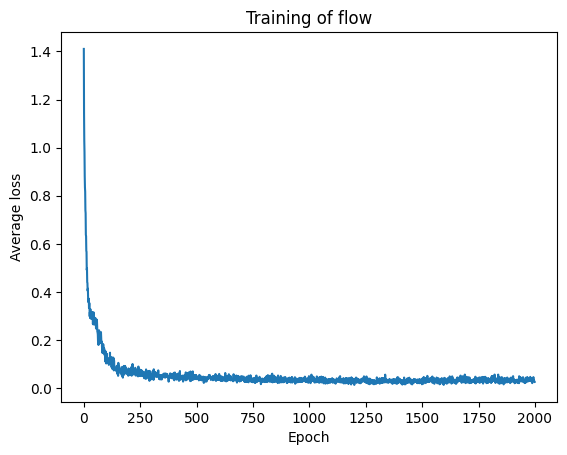

In [14]:
plt.plot(epoch_list, loss_list)
plt.title('Training of flow')
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.show()

In [15]:

# ---- save state dicts
torch.save({
    'vf_state': vf_model.state_dict(),
    'cell_conditioner_state': cell_conditioner.state_dict(),
    'latent_dim': latent_dim,
    'num_cell_types': num_cell_types,
}, flow_model_save_path)
print("Saved model state to", flow_model_save_path)

Saved model state to /dtu/blackhole/1e/213566/models/simple_flow_model_state.pth


In [16]:


# ---- sampling with classifier-free guidance (generate latent samples conditioned on a desired cell type)
def sample_with_cfg(vf_model, cell_conditioner, target_type_idx:int, n_samples=1000, guidance_scale=2.0, n_steps=50, dt=1.0/50, device='cpu'):
    vf_model.eval()
    cell_conditioner.eval()
    latent_dim = next(vf_model.parameters()).shape[-1] if False else latent_dim_global  # we'll supply latent_dim_global below

    # initial noise
    x = torch.randn(n_samples, latent_dim, device=device)

    # conditioning vectors
    # z_cond: conditioning embedding for the requested cell type (broadcasted to n_samples)
    type_idx_tensor = torch.full((n_samples,), target_type_idx, dtype=torch.long, device=device)
    z_cond = cell_conditioner(type_idx_tensor)  # (n_samples, latent_dim)
    # z_uncond: null token (zeros)
    z_uncond = torch.zeros(n_samples, latent_dim, device=device)

    t = torch.zeros(n_samples, 1, device=device)  # starting t=0, we'll step forward to t=1 (note: your alpha/beta definitions use t in [0,1])
    # We trained with sampling x from p_t(x|z) with t drawn ~ Uniform(0,1). For sampling path integration: integrate from t=0 to t=1 with learned vector field
    for step in range(n_steps):
        # compute current time (t scalar for this step) as a tensor matching batch
        # in our simple Euler loop we keep t increasing uniformly
        # t is used inside the network TimeEmbedder; we keep it as current t
        # compute predictions for cond and uncond
        v_uncond = vf_model(x, z_uncond, t)
        v_cond = vf_model(x, z_cond, t)
        # classifier-free guidance: uncond + scale * (cond - uncond)
        v_guided = v_uncond + guidance_scale * (v_cond - v_uncond)

        # Euler step
        x = x + v_guided * dt

        # increment time
        t = t + dt

    return x



In [17]:
# convenience helper to provide latent_dim into sampling function
latent_dim_global = latent_dim  # make available for sampling helper above

# Example: generate 1000 samples conditioned on the first cell type
target_type_idx_example = 0
generated = sample_with_cfg(vf_model, cell_conditioner, target_type_idx_example, n_samples=1000,
                            guidance_scale=guidance_scale, n_steps=n_steps, dt=dt, device=device)

print("Generated shape:", generated.shape)
torch.save(generated.cpu(), generated_save_path)
print("Saved generated latent to", generated_save_path)

Generated shape: torch.Size([1000, 50])
Saved generated latent to /dtu/blackhole/1e/213566/gen_data/pbmc3k/simple_generated_latent.pt


In [1]:
# this the cleaner version of the flow matching model
# import all packages and data
# the data comes from the encoder in 50 dimensional format
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math
import anndata as ad
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load the encoded data from the autoencoder
input_file_path = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train_with_latent.h5ad"
flow_model_save_path = "/dtu/blackhole/1e/213566/models/simple_flow_model.pt"
adata = ad.read_h5ad(input_file_path)

# Access latent representation
latent = adata.obsm["X_latent"]
# make it to a tensor and save in GPU
latent_tensor = torch.tensor(latent, dtype=torch.float32, device = device)
print("Shape of latent space:", latent.shape)
print(latent[:5])

Shape of latent space: (2110, 50)
[[-4.8265247e+00  6.4398712e-01  2.9313943e-01  3.0890481e+00
   1.1765828e+00 -7.8912878e-01 -5.3665400e+00 -1.3968008e+00
   1.2098600e+00  3.3365767e+00 -3.8481004e+00  7.0330495e-01
  -3.4451597e+00  4.1077366e+00  4.2849655e+00  6.9920130e+00
   3.0892158e+00 -7.6523461e+00 -1.8158824e+00  2.7222965e+00
  -2.8834870e+00 -2.7645674e+00  1.6244851e+00  4.3940554e+00
   6.3701739e+00 -2.4180744e+00  3.1864629e+00 -1.7486143e+00
  -2.4821444e+00  5.4535675e+00 -3.1519279e+00  2.4320188e+00
  -3.4471009e+00  1.7183326e+00 -1.6651822e+00  5.9247975e+00
  -5.0021301e-04  2.7415204e+00  3.2821023e+00  6.1637068e+00
  -6.2996321e+00  3.1250734e+00  1.8593316e+00 -7.3208661e+00
  -1.1019467e+00 -1.6716359e+00  6.3101897e+00  6.6704327e-01
   1.1906556e+00  9.7726297e+00]
 [ 1.5488584e+00  8.6747295e-01  2.4328077e+00  5.4669249e-01
  -1.4461365e+00  9.0370119e-01 -1.4667183e+00  5.5467706e+00
   2.7354531e+00  5.1444712e+00 -3.5800772e+00  6.4247775e-01
   

In [3]:
# This is a way of encoding our data for empirical data
class EmpiricalDistribution(torch.nn.Module):
    def __init__(
        self,
        data: torch.Tensor,
        bandwidth: Optional[float] = None,
        compute_log_density: bool = True,
    ):
        super().__init__()
        assert data.dim() == 2, "data must be shape (N, D)"
        data = data.contiguous()
        
        self.register_buffer("data", data)   # (N, D)
        self.n = data.shape[0]
        self.data_dim = data.shape[1]        # <-- renamed attribute
        self.compute_log_density_flag = compute_log_density

        # Bandwidth estimation
        if bandwidth is None:
            std = torch.std(data, dim=0).mean().item()
            factor = (4.0 / (self.data_dim + 2.0)) ** (1.0 / (self.data_dim + 4.0))
            bw = factor * (self.n ** (-1.0 / (self.data_dim + 4.0))) * (std + 1e-6)
            self.bandwidth = torch.tensor(float(bw), device=self.data.device)
        else:
            self.bandwidth = torch.tensor(float(bandwidth), device=self.data.device)

        self._log_const = -0.5 * self.data_dim * math.log(2.0 * math.pi) - self.data_dim * torch.log(self.bandwidth).item()

    @property
    def dim(self):
        return self.data_dim
    def sample(self, num_samples: int) -> torch.Tensor:
        idx = torch.randint(0, self.n, (num_samples,), device=self.data.device)
        return self.data[idx]

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        if not self.compute_log_density_flag:
            raise RuntimeError("log_density disabled (compute_log_density=False).")

        assert x.dim() == 2 and x.shape[1] == self.data_dim

        x = x.to(self.data.device)
        x_norm2 = (x ** 2).sum(dim=1, keepdim=True)
        data_norm2 = (self.data ** 2).sum(dim=1).unsqueeze(0)
        cross = x @ self.data.t()
        d2 = x_norm2 + data_norm2 - 2.0 * cross

        sigma2 = (self.bandwidth ** 2).item()
        exponents = -0.5 * d2 / (sigma2 + 1e-12)
        lse = torch.logsumexp(exponents, dim=1, keepdim=True)

        log_prob = math.log(1.0 / self.n) + lse + self._log_const
        return log_prob

In [4]:
# lets test if the empirical distribution class actually works
# the data has to be a torch tensor

dist = EmpiricalDistribution(latent_tensor)
samples = dist.sample(3)
logp = dist.log_density(samples)
print(logp)

# it seems to work

tensor([[-111.4463],
        [-111.4463],
        [-111.4463]], device='cuda:0')


In [5]:
# we have to have a class that can draw from a Gaussian distribution

class Gaussian(torch.nn.Module):
    """
    Multivariate Gaussian distribution
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        """
        mean: shape (dim,)
        cov: shape (dim,dim)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def dim(self) -> int:
        return self.mean.shape[0]

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))
        
    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

    @classmethod
    def isotropic(cls, dim: int, std: float) -> "Gaussian":
        mean = torch.zeros(dim)
        cov = torch.eye(dim) * std ** 2
        return cls(mean, cov)

In [6]:
# We want to go with Gaussian probability path, therefore we need to load functions for alpha and beta
class LinearAlpha():
    """Implements alpha_t = t"""
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return t  # linear in time

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return torch.ones_like(t)  # derivative of t is 1


class LinearBeta():
    """Implements beta_t = 1 - t"""
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return 1 - t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return -torch.ones_like(t)  # derivative of 1 - t is -1



In [7]:
class GaussianConditionalProbabilityPath():
    def __init__(self, p_data, alpha, beta):
        self.p_data = p_data 
        p_simple = Gaussian.isotropic(p_data.dim, 1.0)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z ~ p_data(x)
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        return self.p_data.sample(num_samples)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
        
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """ 
        alpha_t = self.alpha(t) # (num_samples, 1)
        beta_t = self.beta(t) # (num_samples, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
        - conditional_score: conditional score (num_samples, dim)
        """ 
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

In [8]:
alpha = LinearAlpha()
beta = LinearBeta()
emp_dist=

path = GaussianConditionalProbabilityPath(
    p_data=emp_dist,
    alpha=alpha,
    beta=beta
)
print(path)

NameError: name 'emp_dist' is not defined

In [90]:
# now that we were able to construct a Gaussian probability path, we have to be able to make a conditional vector field

class ConditionalVectorFieldODE():
    def __init__(self, path, z: torch.Tensor):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.path = path
        self.z = z

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t)

In [91]:
cvf_ode = ConditionalVectorFieldODE(path, z)


In [92]:
# now we somehow want to model the marginal vector field from the conditonal vector field
# for that we will use eulers:
class EulerSimulator():
    def __init__(self, ode, z: torch.Tensor):
        self.ode = ode
        self.z = z

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: float):
        
        # Expand z to match batch size
        if self.z.shape[0] == 1:
            z_exp = self.z.expand(xt.shape[0], -1)
        else:
            z_exp = self.z
        dx = self.ode.drift_coefficient(xt, t, z_exp)
        return xt + dx * h



In [93]:
import math
import torch.nn as nn

class TimeEmbedder(nn.Module):
    def __init__(self, embed_dim=32, max_freq=1e4):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_freq = max_freq
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU()
        )

    def forward(self, t):
        freqs = torch.exp(torch.linspace(0, math.log(self.max_freq), self.embed_dim // 2, device=t.device))
        args = t * freqs
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.mlp(emb)

class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        return x + self.block(x)

class NeuralVectorField(nn.Module):
    def __init__(self, latent_dim, hidden_dim=128, n_resblocks=3, time_embed_dim=32):
        super().__init__()
        self.x_proj = nn.Linear(latent_dim, hidden_dim)
        self.z_proj = nn.Linear(latent_dim, hidden_dim)
        self.time_embedder = TimeEmbedder(time_embed_dim)

        self.resblocks = nn.ModuleList([
            ResNetBlock(hidden_dim*2 + time_embed_dim) for _ in range(n_resblocks)
        ])
        self.output_layer = nn.Linear(hidden_dim*2 + time_embed_dim, latent_dim)

    def forward(self, x, z, t):
        xh = self.x_proj(x)
        zh = self.z_proj(z)
        th = self.time_embedder(t)
        h = torch.cat([xh, zh, th], dim=-1)
        for block in self.resblocks:
            h = block(h)
        return self.output_layer(h)


In [94]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 2110
num_epochs = 5000
learning_rate = 1e-3
latent_dim = latent_tensor.shape[1]  # e.g., 50
epochs_list = []
loss_list = []

vf_model = NeuralVectorField(latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(vf_model.parameters(), lr=learning_rate)

# Initialize GaussianConditionalProbabilityPath and ConditionalVectorFieldODE
path = GaussianConditionalProbabilityPath(emp_dist, alpha, beta)  # define alpha, beta
cvf_ode = ConditionalVectorFieldODE(path, z=torch.zeros(1, latent_dim, device=device))

for epoch in range(num_epochs):
    # --- Sample conditioning variable z ---
    z = emp_dist.sample(batch_size).to(device)

    # --- Sample time ---
    t = torch.rand(batch_size, 1, device=device)

    # --- Sample x_t from conditional path ---
    with torch.no_grad():
        x = path.sample_conditional_path(z, t)
        u_target = path.conditional_vector_field(x, z, t)

    # --- Normalize target ---
    u_mean = u_target.mean(dim=0, keepdim=True)
    u_std = u_target.std(dim=0, keepdim=True) + 1e-6
    u_target_norm = (u_target - u_mean) / u_std

    # --- Forward pass ---
    v_pred = vf_model(x, z, t)

    # --- Loss ---
    loss = F.mse_loss(v_pred, u_target_norm)

    # --- Backprop ---
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(vf_model.parameters(), max_norm=1.0)
    optimizer.step()

    # --- Save stats ---
    epochs_list.append(epoch)
    loss_list.append(float(loss))

    if epoch % 50 == 0:
        print(f"[{epoch}] Loss: {loss.item():.6f}")


[0] Loss: 1.900425
[50] Loss: 0.076403
[100] Loss: 0.064227
[150] Loss: 0.061644
[200] Loss: 0.053724
[250] Loss: 0.035737
[300] Loss: 0.027486
[350] Loss: 0.023804
[400] Loss: 0.021102
[450] Loss: 0.019818
[500] Loss: 0.017939
[550] Loss: 0.016885
[600] Loss: 0.015444
[650] Loss: 0.015229
[700] Loss: 0.013819
[750] Loss: 0.013889
[800] Loss: 0.013724
[850] Loss: 0.012990
[900] Loss: 0.012491
[950] Loss: 0.012056
[1000] Loss: 0.011001
[1050] Loss: 0.011520
[1100] Loss: 0.011166
[1150] Loss: 0.012368
[1200] Loss: 0.010196
[1250] Loss: 0.010411
[1300] Loss: 0.010866
[1350] Loss: 0.010570
[1400] Loss: 0.011119
[1450] Loss: 0.009777
[1500] Loss: 0.010421
[1550] Loss: 0.010046
[1600] Loss: 0.010495
[1650] Loss: 0.010226
[1700] Loss: 0.009873
[1750] Loss: 0.009400
[1800] Loss: 0.010520
[1850] Loss: 0.009726
[1900] Loss: 0.008957
[1950] Loss: 0.009032
[2000] Loss: 0.009762
[2050] Loss: 0.008079
[2100] Loss: 0.008867
[2150] Loss: 0.009604
[2200] Loss: 0.009041
[2250] Loss: 0.009238
[2300] Loss

In [ ]:
plt.plot(epoch_list, loss_list)
plt.title('Training of flow')
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.show()

In [95]:
# we want to save the best vector field:
class LearnedVectorFieldODE():
    def __init__(self, vf_model):
        self.vf_model = vf_model

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        # x, z: (batch_size, latent_dim)
        # t: (batch_size, 1)
        return self.vf_model(x, z, t)


In [97]:
# Wrap the trained neural network
learned_ode = LearnedVectorFieldODE(vf_model)

# Save the wrapper
torch.save(learned_ode, flow_model_save_path)


In [96]:
# Number of samples and latent dimension
n_samples = 1000
latent_dim = latent_tensor.shape[1]

# Starting points (noise)
x = torch.randn(n_samples, latent_dim, device=device)

# Conditioning variable z
# Single vector, broadcast to all samples
z = torch.zeros(1, latent_dim, device=device)  # or z = emp_dist.sample(1)

# Wrap the trained neural network as an ODE
learned_ode = LearnedVectorFieldODE(vf_model)

# Create Euler simulator with the conditioning variable
simulator = EulerSimulator(learned_ode, z)

# Simulation parameters
t0, t1 = 0.0, 1.0
n_steps = 50
dt = (t1 - t0) / n_steps

# Store trajectory
trajectory = [x.clone()]
t = torch.full((n_samples, 1), t0, device=device)

# Euler integration
for _ in range(n_steps):
    x = simulator.step(x, t, dt)
    trajectory.append(x.clone())
    t = t + dt

# Final generated samples
generated_cells = trajectory[-1]
print(generated_cells.shape)  # (1000, latent_dim)
torch.save(generated_cells, "/dtu/blackhole/1e/213566/gen_data/pbmc3k/simple_generated_latent.pt")


torch.Size([1000, 50])
